## Verifizierung

Hier werden die Portfolio-Optimierungsmethoden und Vergleichsmetriken anhand eines kleinen Beispieldatensatzes getestet, erläutert und validiert. Hierzu werden auch in den angehangenen Excel-Dateien Methoden Und Metriken händisch gerechnet und mit den Pyhton-Implementierungen verglichen. Dies dient der Qualitätssicherung der Implementierungen.

#### Importe

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from riskfolio import HCPortfolio as hc
#from riskfolio import plotting as pl

#### Abruf der Beispieldaten

In [2]:
#Beispiel: Abruf von Daten aus Yahoo Finance über Ticker und Erstellung einer Kovarianzmatrix

stocks_example = "WTW TSLA SBUX PEP NVDA NKE NFLX MSFT KO BA"

start_date = "2024-01-01"
end_date = "2025-07-31"

stock = yf.download(stocks_example, start=start_date, end=end_date, auto_adjust=False)
df = stock['Adj Close']
corr = df.corr()

cmap = sb.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap).format(precision = 2)

[*********************100%***********************]  10 of 10 completed


Ticker,BA,KO,MSFT,NFLX,NKE,NVDA,PEP,SBUX,TSLA,WTW
Ticker,,,,,,,,,,
BA,1.00,-0.12,0.41,0.19,0.21,-0.13,-0.36,-0.11,-0.00,-0.27
KO,-0.12,1.00,0.25,0.71,-0.75,0.57,-0.48,0.24,0.32,0.65
MSFT,0.41,0.25,1.00,0.57,-0.25,0.70,-0.40,-0.03,0.39,0.13
NFLX,0.19,0.71,0.57,1.00,-0.76,0.72,-0.88,0.36,0.70,0.77
NKE,0.21,-0.75,-0.25,-0.76,1.00,-0.61,0.67,-0.07,-0.58,-0.72
NVDA,-0.13,0.57,0.70,0.72,-0.61,1.00,-0.44,0.29,0.65,0.62
PEP,-0.36,-0.48,-0.40,-0.88,0.67,-0.44,1.00,-0.23,-0.63,-0.61
SBUX,-0.11,0.24,-0.03,0.36,-0.07,0.29,-0.23,1.00,0.47,0.63
TSLA,-0.00,0.32,0.39,0.70,-0.58,0.65,-0.63,0.47,1.00,0.73


In [3]:
df.info

<bound method DataFrame.info of Ticker              BA         KO        MSFT        NFLX         NKE  \
Date                                                                    
2024-01-02  251.759995  56.383640  365.421570   46.849998  102.348778   
2024-01-03  243.910004  56.515598  365.155640   47.026001   99.937744   
2024-01-04  244.940002  56.327087  362.534637   47.466999   98.266373   
2024-01-05  249.000000  56.242260  362.347473   47.405998   98.055038   
2024-01-08  229.000000  56.656982  369.185486   48.502998   99.534309   
...                ...        ...         ...         ...         ...   
2025-07-24  231.270004  68.095802  509.088745  118.075996   74.554108   
2025-07-25  233.059998  68.164787  511.908844  118.049004   75.394341   
2025-07-28  236.410004  67.100479  510.703033  117.459999   78.330246   
2025-07-29  226.080002  68.371735  510.772797  116.874001   77.430695   
2025-07-30  225.839996  67.750893  511.440430  118.419998   75.799637   

Ticker            

In [4]:
returns = df.pct_change()
returns = returns.iloc[1:]
returns.info

<bound method DataFrame.info of Ticker            BA        KO      MSFT      NFLX       NKE      NVDA  \
Date                                                                     
2024-01-03 -0.031180  0.002340 -0.000728  0.003757 -0.023557 -0.012436   
2024-01-04  0.004223 -0.003336 -0.007178  0.009378 -0.016724  0.009019   
2024-01-05  0.016575 -0.001506 -0.000516 -0.001285 -0.002151  0.022897   
2024-01-08 -0.080321  0.007374  0.018871  0.023141  0.015086  0.064281   
2024-01-09 -0.014148 -0.001830  0.002936 -0.006061 -0.008493  0.016975   
...              ...       ...       ...       ...       ...       ...   
2025-07-24 -0.011160 -0.000868  0.009904  0.003382 -0.017329  0.017332   
2025-07-25  0.007740  0.001013  0.005540 -0.000229  0.011270 -0.001381   
2025-07-28  0.014374 -0.015614 -0.002356 -0.004989  0.038941  0.018732   
2025-07-29 -0.043695  0.018946  0.000137 -0.004989 -0.011484 -0.007016   
2025-07-30 -0.001062 -0.009080  0.001307  0.013228 -0.021065  0.021423   

Ticke

In [5]:
cov_matrix = returns.cov()
cov_matrix

Ticker,BA,KO,MSFT,NFLX,NKE,NVDA,PEP,SBUX,TSLA,WTW
Ticker,,,,,,,,,,
BA,0.000556,0.000009,0.000094,0.000118,0.000179,0.000201,0.000003,0.000164,0.000370,0.000053
KO,0.000009,0.000094,-0.000004,-0.000005,0.000036,-0.000079,0.000073,0.000030,-0.000029,0.000038
MSFT,0.000094,-0.000004,0.000211,0.000142,0.000079,0.000284,-0.000002,0.000082,0.000256,0.000020
NFLX,0.000118,-0.000005,0.000142,0.000408,0.000069,0.000323,-0.000019,0.000078,0.000258,0.000024
NKE,0.000179,0.000036,0.000079,0.000069,0.000583,0.000109,0.000069,0.000242,0.000213,0.000051
NVDA,0.000201,-0.000079,0.000284,0.000323,0.000109,0.001195,-0.000079,0.000178,0.000542,-0.000015
PEP,0.000003,0.000073,-0.000002,-0.000019,0.000069,-0.000079,0.000156,0.000053,0.000004,0.000057
SBUX,0.000164,0.000030,0.000082,0.000078,0.000242,0.000178,0.000053,0.000559,0.000257,0.000042
TSLA,0.000370,-0.000029,0.000256,0.000258,0.000213,0.000542,0.000004,0.000257,0.001816,0.000047


In [6]:
df.to_csv("Verifizierung.csv")

## Implementierung der Optimierungsmethoden

### Equally-Weighted Portfolio

In [7]:
#Rückgabe gleicher Gewichte anhand der Anzahl der Unternehmen (Input Returns)

def equally_weighted(returns):
    anzahl_assets = returns.shape[1]

    w0 = 1/anzahl_assets
    gewichte = np.full(anzahl_assets, w0)

    return gewichte

In [8]:
#Validierung per Berechnung Return

###Berechnung der Rendite erfolgt in Excel-Datei im Tabellenblatt EW, Endergebnis identisch zur Python-Implementierung

gewichte_ew = equally_weighted(returns)
daily_returns = returns @ gewichte_ew

mean = daily_returns.mean()

print (mean)

0.0009801237229138302


### Minimum-Variance Portfolio

Es gilt die Portfolio-Varianz zu minimieren, mathematisch also die Zielfunktion "wT * cov_matrix * w" (objective). Bei der Anpassung der Gewichte sollen die Bedingungen gelten, dass sich alle Gewichte zu 1 aufaddieren und das alle Gewichte zwischen 0 und 1 liegen (constraints und bounds). Als initiale Annahme für die Optimierung gilt Gleichgewicht (equally weighted), optimiert wird mit SLSQP. In Excel wird der Solver verwendet.

In [9]:
#Minimum-Variance Portfolio
#Code adaptiert von https://medium.com/@BorisGerat/mean-variance-and-minimum-variance-portfolio-models-in-python-64a5c6b57b2d

def min_variance_opt(matrix):
    
    #Compute the minimum-variance portfolio weights subject to the constraints of:
    #- No short-selling (weights must be >= 0)
    #- Full investment (sum of weights must equal 1)
    
    number_of_assets = matrix.shape[0]

    # Define the objective function to minimize portfolio variance
    def objective(w):
        portfolio_variance = np.dot(w, matrix @ w)
        print(portfolio_variance)
        return portfolio_variance

    # Constraint: The sum of portfolio weights must be equal to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    print(constraints)

    # Bounds: Each weight must be between 0 and 1 (no short-selling)
    bounds = [[0, 1] for _ in range(number_of_assets)]
    print(bounds)

    # Initial guess: Equal weights for all assets
    w0 = np.ones(number_of_assets) / number_of_assets
    print (w0)

    # Solve the optimization problem using Sequential Least Squares Quadratic Programming (SLSQP)
    res = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints, options={'ftol': 1e-12, 'disp': True, 'maxiter': 1000})
    
    print(res)
    
    return res.x  # Return the optimal weights

In [10]:
#Auswertung Minimum-Variance Portfolio

mv_gewichte = min_variance_opt(cov_matrix)

print(mv_gewichte)

[{'type': 'eq', 'fun': <function min_variance_opt.<locals>.<lambda> at 0x000002B77C3874C0>}]
[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.00014949898552702007
0.0001494989907294152
0.00014949898600956162
0.0001494989889855589
0.00014949898968439994
0.00014949899038708308
0.000149498993449944
0.00014949898646498996
0.0001494989905468522
0.00014949899664998988
0.00014949898691657702
0.00014906653258730954
0.0001490665377828932
0.00014906653307219847
0.00014906653604075833
0.0001490665367391856
0.0001490665374440428
0.00014906654049360397
0.00014906653352767633
0.0001490665376024877
0.0001490665436820343
0.00014906653397785515
0.00014692839506473602
0.00014692840022634927
0.00014692839556132813
0.0001469283984928102
0.00014692839918917333
0.00014692839990484128
0.0001469284028881248
0.00014692839601705265
0.00014692840005668895
0.000146928406018669
0.00014692839646021123
0.00013682725131817266
0.00013682725631

5.495893565911952e-05
5.4958937330607186e-05
5.4958937201871466e-05
5.495893733601193e-05
5.495893727058661e-05
5.495893749235285e-05
5.495893733239471e-05
5.495893743075104e-05
5.49589375416142e-05
5.495893807043883e-05
5.4958937325117484e-05
5.469970677706868e-05
5.469970836306208e-05
5.469970833286305e-05
5.469970847689678e-05
5.4699708468234734e-05
5.4699708564054204e-05
5.469970843255909e-05
5.469970849398101e-05
5.469970860830506e-05
5.469970914507408e-05
5.4699708406874e-05
5.4515415287885016e-05
5.451541680112e-05
5.4515416866351865e-05
5.451541700545183e-05
5.4515416973513466e-05
5.451541701199967e-05
5.451541692203751e-05
5.451541695609013e-05
5.4515417009492864e-05
5.451541758964346e-05
5.45154168789126e-05
5.44648416911929e-05
5.44648431881049e-05
5.446484328337894e-05
5.446484341142653e-05
5.4464843321028426e-05
5.4464843383648196e-05
5.446484331591011e-05
5.446484334680725e-05
5.446484333897179e-05
5.446484395618185e-05
5.446484326754807e-05
5.44603037380036e-05
5.4460305

Die zu minimierende Funktion erreicht in Python und Excel den (nahezu) gleichen Zielwert, die Gewichte ähneln einander. Python-Implementierung ist mit bis zu 1000 Iterationen sehr fein gewählt

### Maximum-Diversification Portfolio

Das Maximum-Diversification Portfolio nach Choueifaty ist das Portfolio, das die sogenannte Diversification Ratio maximiert. Die Diversification Ratio wird definiert als das Verhältnis der gewichteten durchschnittlichen Volatilitäten zur gesamten Portfolio-Volatilität.

In [11]:
#Code von https://thequantmba.wordpress.com/2017/06/06/max-diversification-in-python/ adaptiert

def calc_max_diversification_ratio(weights, matrix):
    
    # gewichtete Volatilität
    average_vol = np.dot(np.sqrt(np.diag(matrix)), weights.T)
    
    # portfolio volatilität
    portfolio_variance = np.dot(weights, matrix @ weights)
    portfolio_vol = np.sqrt(portfolio_variance)
    
    #Bestimmung Ratio
    diversification_ratio = average_vol/portfolio_vol
    
    print('Ratio: ' , diversification_ratio)
    
    # Negativer Wert für Minimierung (Maximizieren = Minimieren -)
    return -diversification_ratio

In [12]:
#Code von https://thequantmba.wordpress.com/2017/06/06/max-diversification-in-python/ adaptiert

def max_diversification_portfolio(w, matrix):
    
    number_of_assets = matrix.shape[0]
    
    # Constraint: The sum of portfolio weights must be equal to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    # Bounds: Each weight must be between 0 and 1 (no short-selling)
    bounds = [[0, 1] for _ in range(number_of_assets)]
    
    res = minimize(calc_max_diversification_ratio, w, bounds=bounds, args=matrix, method='SLSQP', constraints=constraints, options={'ftol': 1e-12, 'disp': True, 'maxiter': 1000})
    return res

In [13]:
#Test der Implementierung, Vergleich in Excel (gelöst mit Solver) in Tabellenblatt MD
number_of_assets = cov_matrix.shape[0]

#Grundannahme für den Start der Optimierung ist Gleichgewicht
w0 = np.ones(number_of_assets) / number_of_assets

max_div_gewichte = max_diversification_portfolio(w0, cov_matrix)

print(max_div_gewichte)

Ratio:  1.7805959234554845
Ratio:  1.7805959212013933
Ratio:  1.780595932416073
Ratio:  1.7805959205557644
Ratio:  1.7805959232997055
Ratio:  1.7805959239450497
Ratio:  1.780595918398534
Ratio:  1.7805959331117258
Ratio:  1.7805959223816263
Ratio:  1.7805959091470682
Ratio:  1.7805959300979006
Ratio:  1.2346530231476456
Ratio:  1.9188098780754297
Ratio:  1.9188098748267195
Ratio:  1.918809883663822
Ratio:  1.9188098748380604
Ratio:  1.91880987879986
Ratio:  1.9188098753862424
Ratio:  1.9188098778538067
Ratio:  1.9188098822554644
Ratio:  1.9188098743026223
Ratio:  1.9188098619603073
Ratio:  1.9188098812080938
Ratio:  1.7655578522504607
Ratio:  1.977715493127433
Ratio:  1.9777154938078718
Ratio:  1.9777154950131135
Ratio:  1.9777154905452006
Ratio:  1.9777154954884095
Ratio:  1.9777154926194094
Ratio:  1.977715492031644
Ratio:  1.9777154928512364
Ratio:  1.9777154913276365
Ratio:  1.9777154855474768
Ratio:  1.977715494263263
Ratio:  1.7571831814114096
Ratio:  1.9858754033771968
Ratio:  1

Diversification Ratio und Gewichte konnten über die Definition und den Solver in Excel validiert werden

### Inverse-Volatility Portfolio

Beim Inverse-Volatility Portfolio werden die Gewichte so verteilt, dass die Aktien mit der größten Volatilität die kleinsten Gewichte bekommen, während Aktien mit geringer Volatilität größere Gewichte zugeordnet bekommen. Das Gewicht eines Asstes bildet sich aus dem Verhältnis der invertierten Standardabweichung zu der Summe der invertierten Standardabweichungen.

In [14]:
#Code adaptiert von https://www.kaggle.com/code/vijipai/lesson-4-traditional-portfolio-construction-method

def inverse_volatility_portfolio (matrix):
    
    standardabweichungen = np.sqrt(np.diagonal(matrix))
    invertierte_std = 1/standardabweichungen
    summe_invertierte_std = np.sum(invertierte_std)
    
    inverse_volatility_gewichte = invertierte_std / summe_invertierte_std
    
    return inverse_volatility_gewichte

In [15]:
inverse_volatility_gewichte = inverse_volatility_portfolio (cov_matrix)

print(inverse_volatility_gewichte)

[0.07554652 0.18338717 0.12263622 0.08821312 0.07373694 0.05151828
 0.14238538 0.07530265 0.04179077 0.14548296]


### Equally-Weighted-Risk-Contributions Portfolio (Risk Parity)

Das ERC Portfolio nach Maillard berechnet Risk Contributions der Assets und bildet eine Zielfunktion so, dass alle Assets das gleiche Risiko beitragen. Die Marginal Risk Contributions sind definiert als das Verhältnis der Varianz + der Summe der Kovarianzen des Assets zu der Portfolio-Volatilität. Gewichtet ergibt das den Risikobeitrag.

In [16]:
#Code adaptiert von https://medium.com/@deepml1818/building-a-python-based-risk-parity-portfolio-for-trading-40441ecdd84d

def calculate_portfolio_volatility(weights, matrix):
    
    portfolio_variance = np.dot(weights, matrix @ weights)
    portfolio_volatility = np.sqrt(portfolio_variance)
    return portfolio_volatility

def calculate_risk_contribution(weights, matrix):
    portfolio_volatility = calculate_portfolio_volatility(weights, matrix)
    marginal_contribution_zaehler = np.dot(matrix, weights)
    risk_contribution = np.multiply(weights, marginal_contribution_zaehler) / portfolio_volatility
    return risk_contribution

def risk_parity_objective(weights, matrix):
    risk_contribution = calculate_risk_contribution(weights, matrix)
    target_risk = np.mean(risk_contribution)
    print('Mean: ', np.mean(risk_contribution))
    print('Objective: ', np.sum((risk_contribution - target_risk) ** 2))
    return np.sum((risk_contribution - target_risk) ** 2)

In [17]:
def get_risk_parity_weights(w0, matrix):
    number_of_assets = matrix.shape[0]
    initial_weights = w0
    constraints = ({'type': 'eq', 'fun': lambda initial_weights: np.sum(initial_weights) - 1})
    bounds = [[0, 1] for _ in range(number_of_assets)]
    
    result = minimize(risk_parity_objective, initial_weights, args=(matrix), method='SLSQP', bounds=bounds, constraints=constraints, options={'ftol': 1e-12, 'disp': True, 'maxiter': 1000})
    
    return result.x

In [18]:
#Test der Marginal Risk-Contributions

def calculate_marginal_contribution(weights, matrix):
    portfolio_volatility = calculate_portfolio_volatility(weights, matrix)
    marginal_contribution = np.dot(matrix, weights)/portfolio_volatility
    return marginal_contribution

number_of_assets = cov_matrix.shape[0]
w0 = np.ones(number_of_assets) / number_of_assets

marginal_contribution = calculate_marginal_contribution(w0, cov_matrix)

print(marginal_contribution)

[0.01427691 0.00132424 0.00949125 0.01140908 0.01333745 0.02174284
 0.00257407 0.0137759  0.03052471 0.00381335]


In [19]:
#Test der Risk-Contributions

number_of_assets = cov_matrix.shape[0]
w0 = np.ones(number_of_assets) / number_of_assets

risk_contributions = calculate_risk_contribution(w0, cov_matrix)
    
print(risk_contributions)

[0.00142769 0.00013242 0.00094913 0.00114091 0.00133374 0.00217428
 0.00025741 0.00137759 0.00305247 0.00038134]


In [20]:
#Test der Zielfunktion der Risikobeiträge

number_of_assets = cov_matrix.shape[0]
w0 = np.ones(number_of_assets) / number_of_assets

risk_parity_mean = risk_parity_objective(w0, cov_matrix)

print(risk_parity_mean)

Mean:  0.0012226977775681939
Objective:  7.241837369359909e-06
7.241837369359909e-06


In [21]:
# Initial guess: Equal weights for all assets
number_of_assets = cov_matrix.shape[0]
w0 = np.ones(number_of_assets) / number_of_assets

erc_gewichte = get_risk_parity_weights(w0, cov_matrix)
print(erc_gewichte)

Mean:  0.0012226977775681939
Objective:  7.241837369359909e-06
Mean:  0.0012226977988424417
Objective:  7.241837432384109e-06
Mean:  0.0012226977795414596
Objective:  7.241837224450247e-06
Mean:  0.001222697791711259
Objective:  7.241837294680063e-06
Mean:  0.001222697794569042
Objective:  7.241837324239816e-06
Mean:  0.0012226977974425367
Objective:  7.241837289438621e-06
Mean:  0.0012226978099675488
Objective:  7.241838158358054e-06
Mean:  0.0012226977814038511
Objective:  7.241837169709107e-06
Mean:  0.0012226977980958835
Objective:  7.241837345439944e-06
Mean:  0.0012226978230535533
Objective:  7.241839439769952e-06
Mean:  0.0012226977832505341
Objective:  7.241837173365619e-06
Mean:  0.001222356992287726
Objective:  7.221321739972312e-06
Mean:  0.00122235701356349
Objective:  7.221321803475565e-06
Mean:  0.0012223569942631468
Objective:  7.221321595146212e-06
Mean:  0.001222357006430849
Objective:  7.221321665519635e-06
Mean:  0.001222357009289555
Objective:  7.221321695228796e-06

Mean:  0.0009365444192720987
Objective:  9.397507090653343e-07
Mean:  0.0009365444039387381
Objective:  9.397505187540032e-07
Mean:  0.000936544411762614
Objective:  9.397506464607429e-07
Mean:  0.0009365444150697065
Objective:  9.397507172647565e-07
Mean:  0.0009365444203543721
Objective:  9.39750736006887e-07
Mean:  0.0009365444198142548
Objective:  9.39750328541319e-07
Mean:  0.0009365444066147819
Objective:  9.397505396179008e-07
Mean:  0.0009365444197146331
Objective:  9.397507018993032e-07
Mean:  0.0009365444337364039
Objective:  9.397506308695221e-07
Mean:  0.0009365444075926632
Objective:  9.397505672753679e-07
Mean:  0.0009436008312817851
Objective:  9.256255178425213e-07
Mean:  0.000943600851934444
Objective:  9.256256400375796e-07
Mean:  0.0009436008364023969
Objective:  9.256254432898042e-07
Mean:  0.0009436008444290161
Objective:  9.25625572779516e-07
Mean:  0.0009436008477218484
Objective:  9.256256429731389e-07
Mean:  0.0009436008529020889
Objective:  9.256256608959821e-

Mean:  0.0009007207981991717
Objective:  8.087832217112643e-08
Mean:  0.0009007207844220648
Objective:  8.087829005773566e-08
Mean:  0.0009007207920598375
Objective:  8.087835316439574e-08
Mean:  0.0009007207946317711
Objective:  8.087833000310636e-08
Mean:  0.0009007207990433386
Objective:  8.087832268489511e-08
Mean:  0.0009007208032751084
Objective:  8.087833149217166e-08
Mean:  0.000900720787304363
Objective:  8.087833811176789e-08
Mean:  0.0009007207988614974
Objective:  8.087832543169129e-08
Mean:  0.0009007208134456874
Objective:  8.087832556755544e-08
Mean:  0.0009007207880268942
Objective:  8.087834742886834e-08
Mean:  0.0008991065288682838
Objective:  6.995586306336783e-08
Mean:  0.0008991065482958473
Objective:  6.995586619058626e-08
Mean:  0.0008991065345035314
Objective:  6.995582920754972e-08
Mean:  0.0008991065421070328
Objective:  6.995588794790722e-08
Mean:  0.0008991065448301139
Objective:  6.995588411658568e-08
Mean:  0.0008991065489866855
Objective:  6.9955849458682

Mean:  0.0008914734444522175
Objective:  9.829463202681533e-09
Mean:  0.0008914734311346626
Objective:  9.829461483521849e-09
Mean:  0.0008914734380446439
Objective:  9.829452012584555e-09
Mean:  0.0008914734409124255
Objective:  9.829479865043748e-09
Mean:  0.0008914734453803746
Objective:  9.829470155420121e-09
Mean:  0.0008914734491801983
Objective:  9.829468420099616e-09
Mean:  0.0008914734337549402
Objective:  9.8294804006437e-09
Mean:  0.0008914734452016157
Objective:  9.829471167722534e-09
Mean:  0.0008914734594738535
Objective:  9.829468721004541e-09
Mean:  0.0008914734341771407
Objective:  9.829468877620687e-09
Mean:  0.0008913603070694904
Objective:  8.635717912443513e-09
Mean:  0.00089136032644513
Objective:  8.635719783574485e-09
Mean:  0.0008913603130668817
Objective:  8.635711199157508e-09
Mean:  0.0008913603199860214
Objective:  8.635703196235817e-09
Mean:  0.0008913603228293233
Objective:  8.635727229222666e-09
Mean:  0.0008913603272996748
Objective:  8.635718012770304e

In [22]:
# Validierung mit Riskfolio

import riskfolio as rp

port = rp.Portfolio(returns=returns)

port.mu = returns.mean()
port.cov = cov_matrix
port.bounds = [0,1]

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be volatility

w_rp = port.rp_optimization(model=model, rm=rm)

display(w_rp.T)

,BA,KO,MSFT,NFLX,NKE,NVDA,PEP,SBUX,TSLA,WTW
weights,0.068343,0.218704,0.101744,0.084247,0.065475,0.055004,0.15524,0.066068,0.038543,0.146632


### Hierarchical Risk Parity

Es wird der Algorithmus aus dem Paper von Lopez de Prado (2016) verwendet

In [23]:
def getIVP(cov,**kargs): # Compute the inverse-variance portfolio 
    ivp=1./np.diag(cov) 
    ivp/=ivp.sum() 
    return ivp

In [24]:
#------------------------------------------------------------------------------ 
def getClusterVar(cov,cItems): # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems] # matrix slice 
    w_=getIVP(cov_).reshape(-1,1) 
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0] 
    return cVar 

In [25]:
#------------------------------------------------------------------------------ 
def getQuasiDiag(link): # Sort clustered items by distance 
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]]) 
    numItems=link[-1,3] # number of original items 
    while sortIx.max()>=numItems: 
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space 
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems 
        sortIx[i]=link[j,0] # item 1 
        df0=pd.Series(link[j,1],index=i+1) 
        sortIx = pd.concat([sortIx, df0]) # item 2  ####Anpassung wegen neuer Pandas-Version!
        sortIx=sortIx.sort_index() # re-sort 
        sortIx.index=range(sortIx.shape[0]) # re-index 
    return sortIx.tolist() 

In [26]:
#------------------------------------------------------------------------------ 
def getRecBipart(cov,sortIx): # Compute HRP allocation
    w = pd.Series(1,index=sortIx) 
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0: 
        #Bi-Section der Cluster
        cItems = [i[j:k] 
                  for i in cItems 
                  for j, k in ((0, len(i)//2), (len(i)//2, len(i))) 
                  if len(i) > 1]
        for i in range(0, len(cItems), 2): # parse in pairs 
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2 
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1) 
            w[cItems0]*=alpha # weight 1 
            w[cItems1]*=1-alpha # weight 2 
    return w 

In [27]:
#------------------------------------------------------------------------------ 
def correlDist(corr): 
    # A distance matrix based on correlation, where 0<=d[i,j]<=1 
    # This is a proper distance metric 
    dist=((1-corr)/2.)**.5 # distance matrix 
    return dist 

In [28]:
#------------------------------------------------------------------------------ 
def plotCorrMatrix(path,corr,labels=None): # Heatmap of the correlation matrix 
    if labels is None: labels=[] 
        
    plt.pcolor(corr) 
    plt.colorbar() 
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels) 
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels) 
    plt.savefig(path) 
    plt.clf();plt.close() # reset pylab return

In [29]:
def generateData(nObs,size0,size1,sigma1): # Time series of correlated variables 
    
    #1) generating some uncorrelated data 
    np.random.seed(seed=12345);random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable 
    
    #2) creating correlation between the variables 
    cols=[random.randint(0,size0-1) for _ in range(size1)] 
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols))) 
    x=np.append(x,y,axis=1) 
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1)) 
    
    return x,cols

In [30]:
def main(): #1) Generate correlated data 
    
    nObs=10000
    size0=5
    size1=5
    sigma1=0.25
    x,cols=generateData(nObs,size0,size1,sigma1) 
    
    print([(j+1, size0+i) for i, j in enumerate(cols, 1)])
    
    #2) compute and plot correl matrix 
    cov = x.cov()
    corr = x.corr() 
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    
    #3) cluster 
    dist=correlDist(corr) 
    link=sch.linkage(dist,'single') 
    sortIx=getQuasiDiag(link) 
    sortIx=corr.index[sortIx].tolist() # recover labels 
    df0=corr.loc[sortIx,sortIx] # reorder 
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation 
    hrp=getRecBipart(cov,sortIx) 
    print (hrp)
    return

In [31]:
main()

[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


C:\Users\rapha\AppData\Local\Temp\ipykernel_39840\3152815033.py:18: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist,'single')


8     0.071408
3     0.075961
9     0.125317
2     0.067596
10    0.063236
1     0.109945
7     0.103968
5     0.193357
4     0.097549
6     0.091662
dtype: float64


In [32]:
#Austesten an Beispiel-Datensatz
#Erstellen der Korrelationsmatrix

corr_matrix = returns.corr()
corr_matrix

Ticker,BA,KO,MSFT,NFLX,NKE,NVDA,PEP,SBUX,TSLA,WTW
Ticker,,,,,,,,,,
BA,1.000000,0.039610,0.273742,0.247534,0.314451,0.247121,0.010396,0.293648,0.368008,0.182663
KO,0.039610,1.000000,-0.029520,-0.023597,0.152212,-0.236572,0.602318,0.129005,-0.070641,0.315579
MSFT,0.273742,-0.029520,1.000000,0.482762,0.225515,0.564982,-0.009831,0.239818,0.412955,0.111687
NFLX,0.247534,-0.023597,0.482762,1.000000,0.141594,0.462960,-0.076920,0.162775,0.300224,0.097820
NKE,0.314451,0.152212,0.225515,0.141594,1.000000,0.130927,0.227746,0.423984,0.207017,0.174049
NVDA,0.247121,-0.236572,0.564982,0.462960,0.130927,1.000000,-0.182992,0.217688,0.368134,-0.035977
PEP,0.010396,0.602318,-0.009831,-0.076920,0.227746,-0.182992,1.000000,0.178455,0.006886,0.373482
SBUX,0.293648,0.129005,0.239818,0.162775,0.423984,0.217688,0.178455,1.000000,0.254795,0.145627
TSLA,0.368008,-0.070641,0.412955,0.300224,0.207017,0.368134,0.006886,0.254795,1.000000,0.089416


([<matplotlib.axis.XTick at 0x2b77c793670>,
 [Text(0.5, 0, 'BA'),
  Text(1.5, 0, 'KO'),
  Text(2.5, 0, 'MSFT'),
  Text(3.5, 0, 'NFLX'),
  Text(4.5, 0, 'NKE'),
  Text(5.5, 0, 'NVDA'),
  Text(6.5, 0, 'PEP'),
  Text(7.5, 0, 'SBUX'),
  Text(8.5, 0, 'TSLA'),
  Text(9.5, 0, 'WTW')])

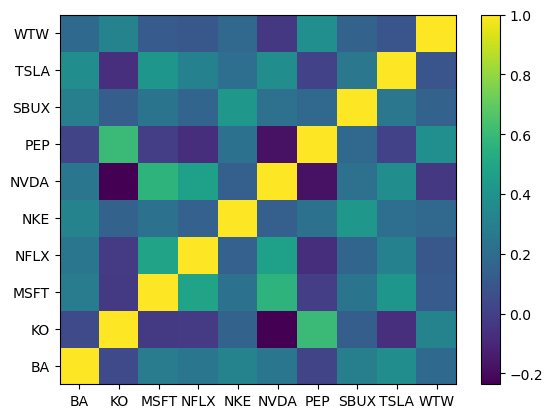

In [33]:
plt.pcolor(corr_matrix) 
plt.colorbar() 
plt.yticks(np.arange(.5,corr_matrix.shape[0]+.5),labels = corr_matrix.columns) 
plt.xticks(np.arange(.5,corr_matrix.shape[0]+.5),labels = corr_matrix.columns) 

In [34]:
#3) Distanzmatrix

distance_matrix = correlDist(corr_matrix) 
distance_matrix

Ticker,BA,KO,MSFT,NFLX,NKE,NVDA,PEP,SBUX,TSLA,WTW
Ticker,,,,,,,,,,
BA,0.000000,0.692961,0.602602,0.613378,0.585469,0.613547,0.703422,0.594286,0.562135,0.639272
KO,0.692961,0.000000,0.717468,0.715401,0.651071,0.786312,0.445916,0.659922,0.731656,0.584988
MSFT,0.602602,0.717468,0.000000,0.508546,0.622288,0.466379,0.710574,0.616515,0.541777,0.666451
NFLX,0.613378,0.715401,0.508546,0.000000,0.655136,0.518189,0.733799,0.647003,0.591513,0.671632
NKE,0.585469,0.651071,0.622288,0.655136,0.000000,0.659194,0.621391,0.536664,0.629676,0.642632
NVDA,0.613547,0.786312,0.466379,0.518189,0.659194,0.000000,0.769088,0.625424,0.562079,0.719714
PEP,0.703422,0.445916,0.710574,0.733799,0.621391,0.769088,0.000000,0.640915,0.704668,0.559695
SBUX,0.594286,0.659922,0.616515,0.647003,0.536664,0.625424,0.640915,0.000000,0.610412,0.653595
TSLA,0.562135,0.731656,0.541777,0.591513,0.629676,0.562079,0.704668,0.610412,0.000000,0.674753


In [35]:
#Komprimierte Form, die nur den Teil über der Diagonale beinhaltet

from scipy.spatial.distance import squareform

condensed_distance_matrix = squareform(X=distance_matrix, checks=False)
condensed_distance_matrix

array([0.692961  , 0.60260183, 0.6133784 , 0.58546944, 0.61354665,
       0.70342162, 0.59428629, 0.56213518, 0.63927197, 0.71746788,
       0.71540101, 0.65107125, 0.78631151, 0.4459159 , 0.65992237,
       0.73165597, 0.58498758, 0.50854611, 0.62228823, 0.46637851,
       0.71057406, 0.61651517, 0.54177704, 0.66645076, 0.65513574,
       0.51818913, 0.73379851, 0.64700288, 0.59151313, 0.67163235,
       0.65919379, 0.62139111, 0.53666385, 0.62967583, 0.64263157,
       0.76908784, 0.62542449, 0.56207929, 0.71971431, 0.64091533,
       0.70466794, 0.55969537, 0.61041182, 0.65359513, 0.67475342])

In [36]:
#Erzeugen der Linkage-Matrix  ACHTUNG: Condensed Matrix notwendig, sonst Warnung

linkage_matrix = linkage(condensed_distance_matrix,'single') 
linkage_matrix

array([[ 1.        ,  6.        ,  0.4459159 ,  2.        ],
       [ 2.        ,  5.        ,  0.46637851,  2.        ],
       [ 3.        , 11.        ,  0.50854611,  3.        ],
       [ 4.        ,  7.        ,  0.53666385,  2.        ],
       [ 8.        , 12.        ,  0.54177704,  4.        ],
       [ 9.        , 10.        ,  0.55969537,  3.        ],
       [ 0.        , 14.        ,  0.56213518,  5.        ],
       [13.        , 16.        ,  0.58546944,  7.        ],
       [15.        , 17.        ,  0.62139111, 10.        ]])

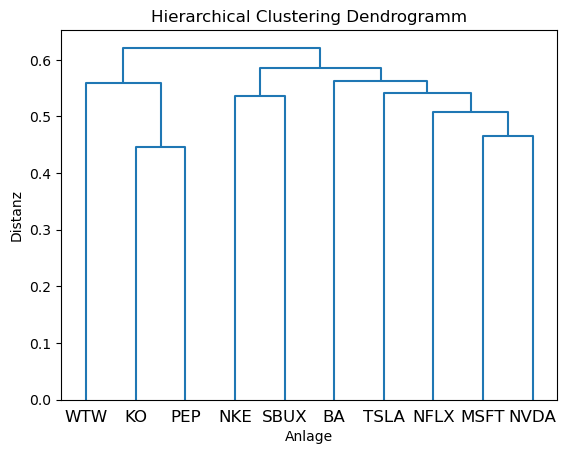

In [37]:
#Visualisierung
dendrogram(linkage_matrix, labels=corr_matrix.columns)
plt.title('Hierarchical Clustering Dendrogramm')
plt.xlabel('Anlage')
plt.ylabel('Distanz')

plt.show()

In [38]:
sortIx = getQuasiDiag(linkage_matrix) 
sortIx = corr_matrix.index[sortIx].tolist() # recover labels 
df0 = corr_matrix.loc[sortIx,sortIx] # reorder 

([<matplotlib.axis.XTick at 0x2b77ca3d0a0>,
 [Text(0.5, 0, 'WTW'),
  Text(1.5, 0, 'KO'),
  Text(2.5, 0, 'PEP'),
  Text(3.5, 0, 'NKE'),
  Text(4.5, 0, 'SBUX'),
  Text(5.5, 0, 'BA'),
  Text(6.5, 0, 'TSLA'),
  Text(7.5, 0, 'NFLX'),
  Text(8.5, 0, 'MSFT'),
  Text(9.5, 0, 'NVDA')])

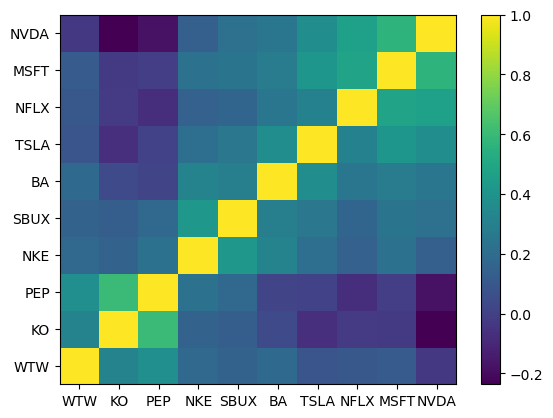

In [39]:
#Visualisierung

plt.pcolor(df0) 
plt.colorbar() 
plt.yticks(np.arange(.5,df0.shape[0]+.5),labels = df0.columns) 
plt.xticks(np.arange(.5,df0.shape[0]+.5),labels = df0.columns) 

In [40]:
#4) Capital allocation 

hrp = getRecBipart(cov_matrix,sortIx) 

#Sortierung der Gewichte zurück zur Reihenfolge der Returns
original_reihenfolge = returns.columns
hrp_sortiert = hrp.reindex(original_reihenfolge)

print(hrp_sortiert)

Ticker
BA      0.057435
KO      0.299201
MSFT    0.095262
NFLX    0.069176
NKE     0.034852
NVDA    0.016811
PEP     0.185040
SBUX    0.036348
TSLA    0.017576
WTW     0.188300
dtype: float64


In [41]:
#Verifizierung der Ergebnisse mit PyportfolioOpt

import pypfopt as ppo

hrp = ppo.hierarchical_portfolio.HRPOpt(
  cov_matrix=cov_matrix,
)

hrp.optimize(linkage_method="single")

OrderedDict([('BA', 0.05743500046769439),
             ('KO', 0.2992008657516257),
             ('MSFT', 0.0952618145959784),
             ('NFLX', 0.06917585874933824),
             ('NKE', 0.03485207381804661),
             ('NVDA', 0.016811404380361657),
             ('PEP', 0.18504005796104514),
             ('SBUX', 0.03634787138197925),
             ('TSLA', 0.017575527874221886),
             ('WTW', 0.18829952501970876)])

### Hierarchical Equal Risk Contribution (HERC) by Raffinot (2018)

In [42]:
#Es wird auf die Implementierung der Riskfolio-Lib zurückgegriffen
#Code adaptiert von #Code adaptiert von https://medium.com/@orenji.eirl/hierarchical-equal-risk-contribution-with-python-and-riskfolio-lib-ec45dd0f9899

def herc (returns):

    # Building the portfolio object
    port = hc(returns=returns)

    # Estimate optimal portfolio:

    model='HERC'
    correlation = 'pearson'
    rm = 'MV'
    rf = 0 
    linkage = 'single' #Anpassung auf single Linkage für Analogie HRP von Lopez de Prado
    max_k = 10 
    leaf_order = True 

    gewichte = port.optimization(model=model,
                          correlation=correlation,
                          rm=rm,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)
    
    #Sortierung der Gewichte zurück zur Reihenfolge der Returns
    original_reihenfolge = returns.columns
    gewichte_sortiert = gewichte.reindex(original_reihenfolge)
    
    array = gewichte_sortiert.T.values

    return array

In [43]:
gewichte = herc(returns)
gewichte

array([[0.00625711, 0.42074468, 0.00786823, 0.00407104, 0.01974049,
        0.00138855, 0.25363639, 0.02058772, 0.00091369, 0.26479209]])

## Implementierung der Vergleichsmetriken

Implementierung der Vergleichsmetriken anhand ihrer Definitionen. Händisch nachgerechnet in Excel zur Validierung

In [44]:
def gesamt_return(gewichte, returns):

    daily_returns = returns @ gewichte
    total = np.prod(1 + daily_returns) - 1
    
    return total

In [45]:
def portfolio_return (gewichte, returns):
    
    avg_returns = []
    avg_returns = returns.mean()
    
    pf_return = sum([gewicht * rendite for gewicht, rendite in zip(gewichte, avg_returns)])
    
    return pf_return

In [46]:
def portfolio_variance (gewichte, returns):
    daily_returns = []
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    pf_var = np.var(daily_returns)
    
    return pf_var

In [47]:
def portfolio_volatility (gewichte, returns):
    variance = portfolio_variance(gewichte, returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [48]:
def sharpe_ratio (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [49]:
def sortino_ratio (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [50]:
def maximum_drawdown (gewichte, returns):
    daily_returns = returns @ gewichte
    returns_kumuliert = (1 + daily_returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [51]:
def calmar_ratio (gewichte, returns):
    pf_return = portfolio_return(gewichte, returns)
    max_drawdown = maximum_drawdown(gewichte, returns)
    
    calmar_ratio = pf_return / max_drawdown
    
    return calmar_ratio

In [52]:
def value_at_risk_func(gewichte, returns):
    daily_returns = returns @ gewichte
    sorted_daily_returns = daily_returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [53]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(gewichte, returns):
    daily_returns = returns @ gewichte
    sorted_daily_returns = daily_returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(gewichte, returns)
    
    expected_shortfall = daily_returns[daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

In [54]:
#Annahme equally weighted
number_of_assets = cov_matrix.shape[0]
w0 = np.ones(number_of_assets) / number_of_assets

#Metriken
return_gesamt = gesamt_return(w0, returns)
return_mean = portfolio_return(w0, returns)
variance = portfolio_variance(w0, returns)
volatility = portfolio_volatility(w0, returns)
sharpe = sharpe_ratio(w0, returns)
sortino = sortino_ratio(w0, returns)
drawdown = maximum_drawdown(w0, returns)
calmar = calmar_ratio(w0, returns)
var = value_at_risk_func(w0, returns)
shortfall = expected_shortfall(w0, returns)

print(return_gesamt)
print(return_mean)
print(variance)
print(volatility)
print(sharpe)
print(sortino)
print(drawdown)
print(calmar)
print(var)
print(shortfall)

0.42887510461833744
0.0009801237229138304
0.00014911954647745906
0.012211451448433927
0.08026267205439593
0.12196445086647596
-0.19713740000571756
-0.0049717796972335235
-0.016033881303161877
-0.027182765490784307


## Rolling-Window Implementation

Rollierende Fenster werden händisch in Excel nachgetestet über den Mean-Return eines Assets

In [55]:
#Datensatz mit 30 Monaten

stocks_example = "WTW TSLA SBUX PEP NVDA NKE NFLX MSFT KO BA"

start_date = "2023-01-01"
end_date = "2025-06-30"

stock = yf.download(stocks_example, start=start_date, end=end_date, auto_adjust=False)
df = stock['Adj Close']
corr = df.corr()

cmap = sb.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap).format(precision = 2)

[*********************100%***********************]  10 of 10 completed


Ticker,BA,KO,MSFT,NFLX,NKE,NVDA,PEP,SBUX,TSLA,WTW
Ticker,,,,,,,,,,
BA,1.00,-0.53,-0.46,-0.48,0.62,-0.68,0.17,0.15,-0.19,-0.64
KO,-0.53,1.00,0.59,0.81,-0.77,0.75,-0.45,-0.08,0.35,0.80
MSFT,-0.46,0.59,1.00,0.78,-0.78,0.90,-0.43,-0.41,0.47,0.67
NFLX,-0.48,0.81,0.78,1.00,-0.89,0.88,-0.77,-0.11,0.65,0.88
NKE,0.62,-0.77,-0.78,-0.89,1.00,-0.87,0.64,0.34,-0.59,-0.78
NVDA,-0.68,0.75,0.90,0.88,-0.87,1.00,-0.50,-0.25,0.57,0.84
PEP,0.17,-0.45,-0.43,-0.77,0.64,-0.50,1.00,0.06,-0.55,-0.62
SBUX,0.15,-0.08,-0.41,-0.11,0.34,-0.25,0.06,1.00,0.18,0.04
TSLA,-0.19,0.35,0.47,0.65,-0.59,0.57,-0.55,0.18,1.00,0.54


In [56]:
#Tägliche Renditen für diesen Zeitraum von 30 Monaten

returns = df.pct_change()
returns = returns.iloc[1:]
returns.info

<bound method DataFrame.info of Ticker            BA        KO      MSFT      NFLX       NKE      NVDA  \
Date                                                                     
2023-01-04  0.042223 -0.000477 -0.043743  0.049025  0.020716  0.030318   
2023-01-05  0.006629 -0.011443 -0.029638  0.000937 -0.004867 -0.032816   
2023-01-06  0.039075  0.019293  0.011785  0.018889  0.032416  0.041640   
2023-01-09 -0.020798 -0.012461  0.009736 -0.001204  0.002570  0.051753   
2023-01-10 -0.009014 -0.007667  0.007617  0.039249  0.007930  0.017981   
...              ...       ...       ...       ...       ...       ...   
2025-06-23  0.012880  0.013074  0.018014  0.017971  0.016558  0.002225   
2025-06-24 -0.001838  0.006739  0.008457  0.020398  0.010530  0.025872   
2025-06-25 -0.010152 -0.008261  0.004407 -0.003018 -0.009606  0.043340   
2025-06-26  0.018502 -0.002298  0.010523  0.024638  0.028111  0.004601   
2025-06-27  0.059088  0.012379 -0.003035  0.012589  0.151903  0.017611   

Ticke

In [57]:
#Definieren von Start und Ende des gesamten Datenbestandes
start_datum = pd.Timestamp('2023-01-01')
end_datum = pd.Timestamp('2025-06-30')

#Definieren der Trainings- und Testzeitfenster in Monaten
training_fenster = 12
test_fenster = 1
 
#Check
training_anfang = start_datum
training_ende = start_datum + pd.DateOffset(months = training_fenster) - pd.DateOffset(days = 1)
test_anfang = training_ende + pd.DateOffset(days = 1)
test_ende = training_ende + pd.DateOffset(months = test_fenster)

print(training_anfang)
print(training_ende)
print(test_anfang)
print(test_ende)

liste_return_means = []

while training_ende + pd.DateOffset(months = test_fenster) <= end_datum:
    training_daten = returns.loc[training_anfang:training_ende]
    test_daten = returns.loc[test_anfang:test_ende]
    
    training_daten_mean = training_daten.iloc[:, 0].mean()
    test_daten_mean = test_daten.iloc[:, 0].mean()
    
    liste_return_means.append(training_daten_mean)
    liste_return_means.append(test_daten_mean)
    
    training_anfang = training_anfang + pd.DateOffset(months = test_fenster)
    training_ende = training_anfang + pd.DateOffset(months = training_fenster) - pd.DateOffset(days = 1)
    test_anfang = training_ende + pd.DateOffset(days = 1)
    test_ende = training_ende + pd.DateOffset(months = test_fenster)
    
print(liste_return_means)

2023-01-01 00:00:00
2023-12-31 00:00:00
2024-01-01 00:00:00
2024-01-31 00:00:00
[0.001303179388485954, -0.00941993479780108, 0.00014931794163547683, -0.00170088202408622, 0.00021909438962494114, -0.0025353123421975655, -0.00021209364195472254, -0.006208195473401331, -0.0006548521251182508, 0.001654621872757762, -0.0003912910761032233, 0.0014324862876970114, -0.000402395011440829, 0.0014273897971722738, -0.0007099062130314906, -0.0038761668977295815, -0.000811563587648786, -0.006373309052827342, -0.0007036018779102287, 0.0008354359283741962, -0.0006647097916142368, 0.0022656640588477883, -0.0013564858479112086, 0.006504314425870667, -0.0013004995561528411, 4.6149485708912865e-06, -0.0005171910694234082, -0.00042893806490265787, -0.00041578856470680627, 9.813522252445361e-05, -0.0002677425462700688, 0.004655032115903013, 0.0006685303829400211, 0.005984365179938199, 0.0009233898043228063, 0.00203684653862675]
